# General Setup
This section contains the general setup that needs to be runned for all the models

## Installation of Dependencies

In [1]:
!pip install git+https://github.com/RobustBench/robustbench.git
!pip install torch
!pip install torchvision
!pip install torchaudio
!pip install foolbox
from IPython.display import clear_output
clear_output()

In [2]:
import torch
from robustbench.data import load_cifar10
from robustbench.utils import load_model
from autoattack import AutoAttack
import foolbox as fb
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import re
import io
from google.colab import drive

# Mount Google Drive for saving results
drive.mount('/content/drive')

# Set up output directory
# all the adversarial examples plot are saved on folder on google drive
output_dir = "/content/drive/My Drive/robustbench_results"
os.makedirs(output_dir, exist_ok=True)

Mounted at /content/drive


## Definition of Variables and Functions

In [3]:
# Define epsilon for AutoAttack and FMN threshold
epsilon = 8 / 255

# Detect device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# List of models to evaluated
# choose the model to test
models = [
    #"Carmon2019Unlabeled"
    "Wang2023Better_WRN-28-10"
    #"Cui2023Decoupled_WRN-28-10"
    #"Xu2023Exploring_WRN-28-10",
    #"Rade2021Helper_extra"
]

# Number of test samples
n_examples = 100
# Nuber of plots of the adversarial samples to show
max_plots_to_show = 1

print("Setup complete.")

Using device: cuda
Setup complete.


In [12]:
def save_and_plot_all_norms(model, model_name, images, labels, adv_images_autoattack, adv_dict, output_dir, max_plots_to_show=1, scaling_factor=10):
    """
    Saves all adversarial perturbation plots to disk and displays a limited number on screen
    for each norm.

    Parameters:
        model: PyTorch model in evaluation mode.
        model_name: String name of the model (used for output directory structure).
        images: Original images tensor.
        labels: True labels tensor.
        adv_images_autoattack: Adversarial images generated by AutoAttack.
        adv_dict: Dictionary with norms as keys and adversarial images (from FMN) as values.
        output_dir: Base output directory to save images.
        max_plots_to_show: Maximum number of plots to display on screen per norm.
        scaling_factor: Factor to scale the perturbations for visualization.
    """
    # Set model to evaluation mode and compute predictions for AutoAttack adversarial images
    model.eval()
    autoattack_preds = model(adv_images_autoattack).argmax(dim=1).cpu().numpy()

    for norm, fmn_adv in adv_dict.items():
        # Create a directory for the current norm
        norm_output_dir = os.path.join(output_dir, model_name, f"{norm}_images")
        os.makedirs(norm_output_dir, exist_ok=True)

        # Get predictions for FMN adversarial images
        fmn_preds = model(fmn_adv).argmax(dim=1).cpu().numpy()

        for i in range(len(images)):
            fig, axes = plt.subplots(1, 5, figsize=(12, 3))

            # Prepare images for display and saving
            original = images[i].cpu().numpy().transpose(1, 2, 0)
            autoattack_img = adv_images_autoattack[i].cpu().numpy().transpose(1, 2, 0)
            fmn_img = fmn_adv[i].cpu().numpy().transpose(1, 2, 0)

            # Compute scaled perturbations
            autoattack_perturb = (autoattack_img - original) * scaling_factor
            fmn_perturb = (fmn_img - original) * scaling_factor

            # Plot the images and their predictions
            axes[0].imshow(np.clip(original, 0, 1))
            axes[0].set_title(f"Original\nLabel: {labels[i].item()}")

            axes[1].imshow(np.clip(autoattack_img, 0, 1))
            axes[1].set_title(f"AutoAttack\nPred: {autoattack_preds[i]}")

            axes[2].imshow(np.clip(fmn_img, 0, 1))
            axes[2].set_title(f"{norm}\nPred: {fmn_preds[i]}")

            axes[3].imshow(np.clip(autoattack_perturb, 0, 1))
            axes[3].set_title("AA Perturbation")

            axes[4].imshow(np.clip(fmn_perturb, 0, 1))
            axes[4].set_title(f"{norm} Perturbation")

            for ax in axes:
                ax.axis("off")

            plt.tight_layout()

            # Save the plot on disk
            image_path = os.path.join(norm_output_dir, f"sample_{i}.png")
            plt.savefig(image_path)

            # Display only the first `max_plots_to_show` samples per norm
            if i < max_plots_to_show:
                plt.show()

            plt.close()

    print("Function execution complete.")


In [5]:
# This function is used to save the values of accuracy and time of AutoAttacks steps to plot a graph in a folloqing cell
def parse_autoattack_log(log: str, model, adv_images, labels, model_name):

    # Regex patterns
    pattern_init    = r'initial accuracy:\s*([\d\.]+)%'
    pattern_apgdce  = r'robust accuracy after APGD-CE:\s*([\d\.]+)% \(total time ([\d\.]+) s\)'
    pattern_apgdt   = r'robust accuracy after APGD-T:\s*([\d\.]+)% \(total time ([\d\.]+) s\)'
    pattern_fabt    = r'robust accuracy after FAB-T:\s*([\d\.]+)% \(total time ([\d\.]+) s\)'
    pattern_square  = r'robust accuracy after SQUARE:\s*([\d\.]+)% \(total time ([\d\.]+) s\)'

    m_init   = re.search(pattern_init, log)
    m_apgdce = re.search(pattern_apgdce, log)
    m_apgdt  = re.search(pattern_apgdt, log)
    m_fabt   = re.search(pattern_fabt, log)
    m_square = re.search(pattern_square, log)

    if m_init and m_apgdce and m_apgdt and m_fabt and m_square:
        initial_acc = float(m_init.group(1))
        apgdce_acc  = float(m_apgdce.group(1))
        apgdce_time = float(m_apgdce.group(2))
        apgdt_acc   = float(m_apgdt.group(1))
        apgdt_time  = float(m_apgdt.group(2))
        fabt_acc    = float(m_fabt.group(1))
        fabt_time   = float(m_fabt.group(2))
        square_acc  = float(m_square.group(1))
        square_time = float(m_square.group(2))
    else:
        print("Error: Unable to parse AutoAttack log output.")
        return {}

    # Build and return the attack_progress dictionary
    times = [0.0, apgdce_time, apgdt_time, fabt_time, square_time]
    accs  = [initial_acc, apgdce_acc, apgdt_acc, fabt_acc, square_acc]
    steps = ["Initial", "APGD-CE", "APGD-T", "FAB-T", "SQUARE"]

    return {model_name: list(zip(times, accs, steps))}


In [6]:
# Load CIFAR-10 test samples
images, labels = load_cifar10(n_examples)
images, labels = images.clone().detach().to(device), labels.clone().detach().to(device)

attack_progress = {}
model_results = {}

fmn_attacks = {
    "Linf": fb.attacks.LInfFMNAttack(),
    "L2": fb.attacks.L2FMNAttack(),
    "L1": fb.attacks.L1FMNAttack(),
    "L0": fb.attacks.L0FMNAttack(),
}

print("Dataset loaded and storage initialized.")

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Dataset loaded and storage initialized.


\# Model 2: Wang2023Better_WRN-28-10


In [7]:
model_name = models[0]
print(f"\n==== Evaluating model: {model_name} ====")

# Load and prepare model
model = load_model(model_name=model_name, dataset="cifar10", threat_model="Linf").to(device)
model.eval()

# Classification before attacks (Clean accuracy)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
clean_accuracy = (predicted == labels).sum().item() / len(labels) * 100
print(f"\nClean Accuracy: {clean_accuracy:.2f}%")
# Print the true labels
print(f"True labels: {labels}")


==== Evaluating model: Wang2023Better_WRN-28-10 ====


Downloading...
From (original): https://drive.google.com/uc?id=1-6MYKJdECDVGaWjj6GgqvaT95BGKhUvI
From (redirected): https://drive.google.com/uc?id=1-6MYKJdECDVGaWjj6GgqvaT95BGKhUvI&confirm=t&uuid=6d22c51c-6e26-40f0-889e-c02cb51bc029
To: /content/models/cifar10/Linf/Wang2023Better_WRN-28-10.pt
100%|██████████| 146M/146M [00:03<00:00, 47.8MB/s]



Clean Accuracy: 93.00%
True labels: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7], device='cuda:0')


## AutoAttack

In [9]:
# Initialize AutoAttack
autoattack = AutoAttack(model, norm='Linf', eps=epsilon, version='standard', device=device)

# Capture stdout while also printing progress
old_stdout = sys.stdout
sys.stdout = mystdout = io.StringIO()
print("\n--- Starting AutoAttack ---")

start_aa = time.time()
adv_images_autoattack = autoattack.run_standard_evaluation(images, labels, bs=50)
end_aa = time.time()

sys.stdout = old_stdout  # Restore stdout
aa_log = mystdout.getvalue()
print(aa_log)  # Print the captured log for visibility

# Get AutoAttack predicted labels
_, predicted_aa = model(adv_images).max(1)
print(f"Predicted labels AA: {predicted_aa}")
correct = torch.sum(labels == predicted_aa).item()
total = len(labels)
print(f"Correct predictions AA: {correct}/{total} ({correct/total*100:.2f}%)")

# Parse log and get attack progress
attack_progress = parse_autoattack_log(aa_log, model, adv_images_autoattack, labels, model_name)


setting parameters for standard version

--- Starting AutoAttack ---
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 93.00%
apgd-ce - 1/2 - 12 out of 50 successfully perturbed
apgd-ce - 2/2 - 10 out of 43 successfully perturbed
robust accuracy after APGD-CE: 71.00% (total time 42.9 s)
apgd-t - 1/2 - 4 out of 50 successfully perturbed
apgd-t - 2/2 - 1 out of 21 successfully perturbed
robust accuracy after APGD-T: 66.00% (total time 313.8 s)
fab-t - 1/2 - 0 out of 50 successfully perturbed
fab-t - 2/2 - 0 out of 16 successfully perturbed
robust accuracy after FAB-T: 66.00% (total time 818.8 s)
square - 1/2 - 0 out of 50 successfully perturbed
square - 2/2 - 0 out of 16 successfully perturbed
robust accuracy after SQUARE: 66.00% (total time 1564.6 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 66.00%

Predicted labels AA: tensor([3, 8, 1, 0, 4, 6, 1, 2, 3, 9, 0, 9, 4, 7, 9, 8, 5, 7, 8, 6, 7, 0, 0, 9,
    


Saved AutoAttack progress plot (all models) to: /content/drive/My Drive/robustbench_results/autoattack_progress_all_models.png



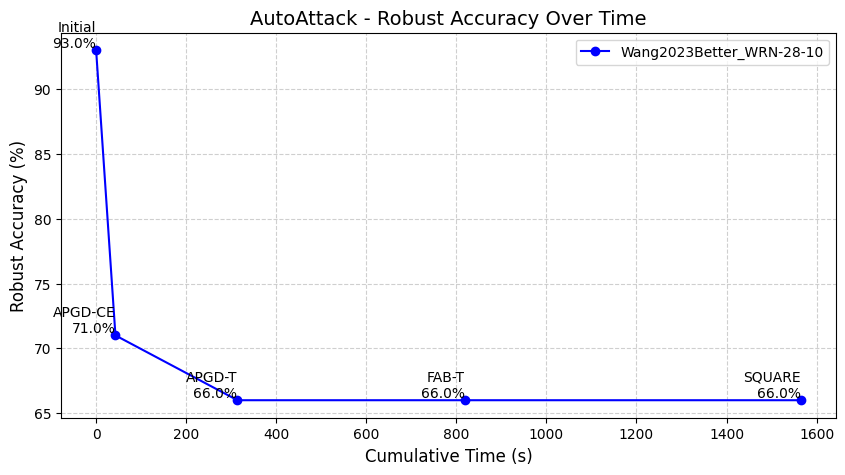

In [10]:
# ----- Plotting AutoAttack Robust Accuracy Flow -----
plt.figure(figsize=(10, 5))
colors = ['blue', 'green', 'orange', 'purple', 'brown']
for idx, (model_name, progress) in enumerate(attack_progress.items()):
    times, accs, steps = zip(*progress)
    plt.plot(times, accs, marker='o', linestyle='-', label=model_name, color=colors[idx % len(colors)])
    for t, acc, step in zip(times, accs, steps):
        plt.text(t, acc, f"{step}\n{acc:.1f}%", fontsize=10, verticalalignment='bottom', horizontalalignment='right')
plt.xlabel("Cumulative Time (s)", fontsize=12)
plt.ylabel("Robust Accuracy (%)", fontsize=12)
plt.title("AutoAttack - Robust Accuracy Over Time", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
autoattack_progress_path = os.path.join(output_dir, "autoattack_progress_all_models.png")
plt.savefig(autoattack_progress_path)
print(f"\nSaved AutoAttack progress plot (all models) to: {autoattack_progress_path}\n")
plt.show()

## FMN


--- Starting FMN Attack (Linf) on model Wang2023Better_WRN-28-10 ---

Attack executed in 58.78 s
Predicted labels FMN (Linf): tensor([5, 0, 0, 8, 4, 4, 9, 2, 5, 9, 3, 1, 3, 5, 1, 6, 3, 3, 0, 3, 3, 2, 0, 1,
        4, 4, 3, 4, 1, 4, 3, 4, 8, 3, 0, 3, 7, 9, 1, 3, 0, 4, 3, 3, 8, 1, 5, 3,
        4, 4, 2, 0, 5, 5, 0, 0, 5, 5, 3, 4, 4, 5, 2, 9, 5, 6, 8, 0, 5, 9, 0, 3,
        0, 0, 9, 4, 0, 5, 5, 0, 0, 9, 9, 3, 5, 7, 3, 8, 0, 8, 8, 4, 0, 5, 6, 3,
        4, 2, 2, 4], device='cuda:0')
Robust Accuracy after FMN (Linf): 0/100 (0.00%)

--- Starting FMN Attack (L2) on model Wang2023Better_WRN-28-10 ---

Attack executed in 57.74 s
Predicted labels FMN (L2): tensor([5, 0, 0, 8, 4, 4, 9, 2, 5, 9, 3, 1, 3, 5, 1, 6, 3, 3, 0, 3, 3, 2, 0, 1,
        4, 4, 3, 4, 1, 4, 3, 4, 8, 3, 0, 3, 7, 9, 1, 3, 0, 4, 3, 3, 8, 1, 5, 3,
        4, 4, 2, 0, 5, 5, 0, 0, 5, 5, 3, 4, 4, 5, 2, 9, 5, 6, 8, 0, 5, 9, 0, 3,
        0, 0, 9, 4, 0, 5, 5, 0, 0, 9, 9, 3, 5, 7, 3, 8, 0, 8, 8, 4, 0, 5, 6, 3,
        4, 2, 2, 4], dev

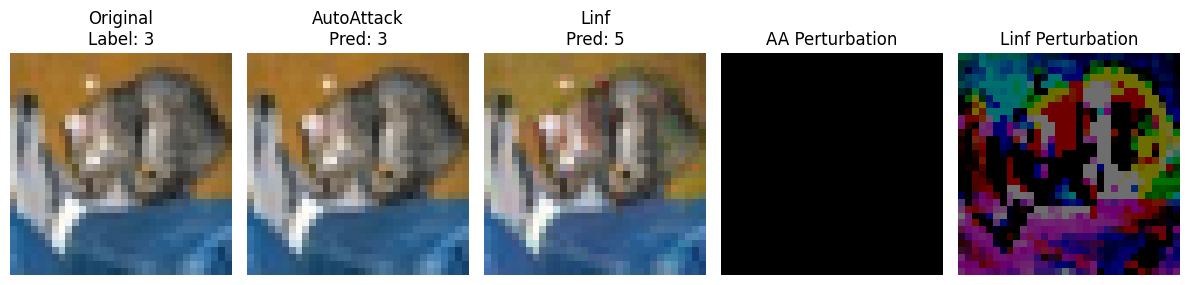

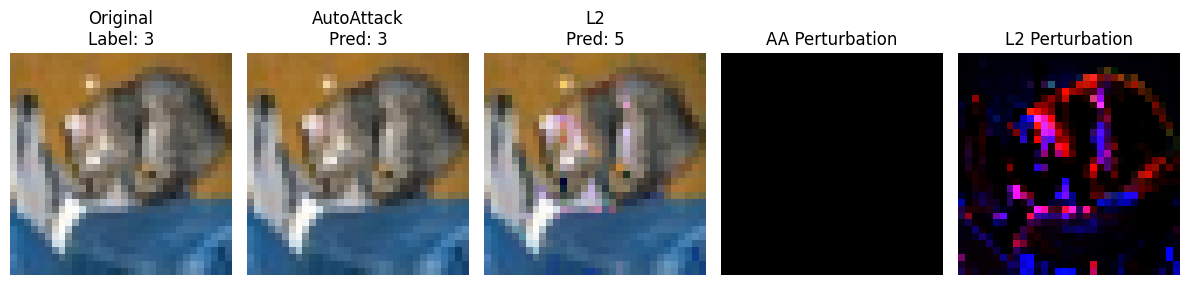

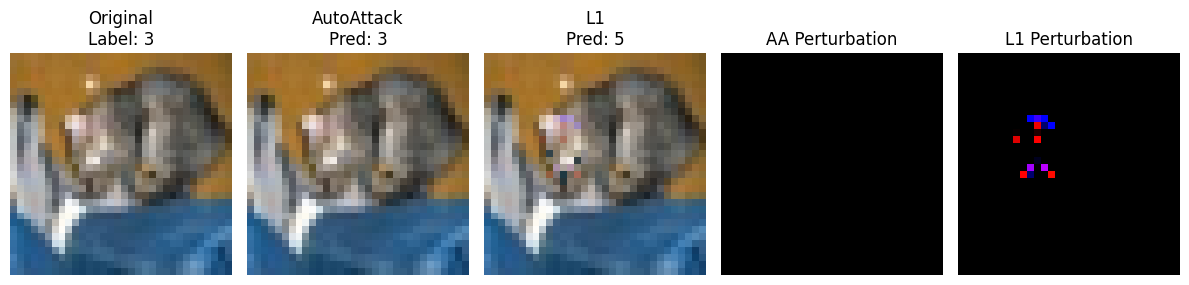

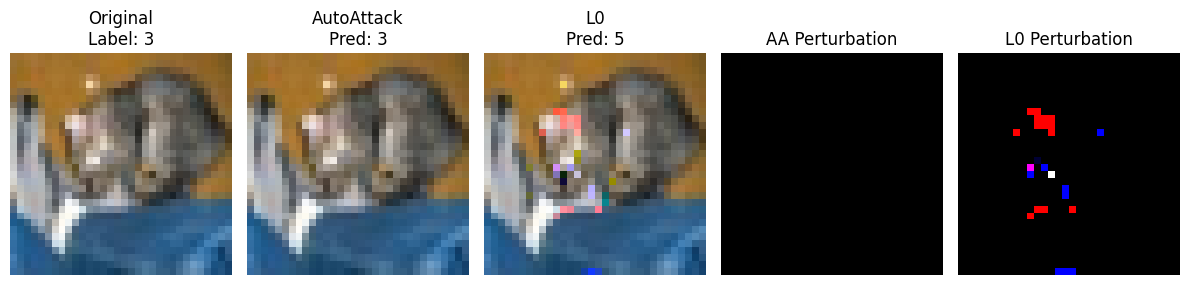

Function execution complete.


In [13]:
# --- FMN Attacks ---
fmodel = fb.PyTorchModel(model, bounds=(0, 1), device=device)
fmn_results = {}
adv_dict = {}

for norm, attack in fmn_attacks.items():
    print(f"\n--- Starting FMN Attack ({norm}) on model {model_name} ---")

    # Capture stdout to track attack progress
    old_stdout = sys.stdout
    sys.stdout = mystdout = io.StringIO()

    start_fmn = time.time()
    _, adv_images, _ = attack(fmodel, images, labels, epsilons=None)
    end_fmn = time.time()

    sys.stdout = old_stdout  # Restore stdout
    fmn_log = mystdout.getvalue()
    print(fmn_log)  # Print captured FMN attack log
    print(f"Attack executed in {end_fmn-start_fmn:.2f} s")

  # Get FMN predicted labels and wrong indexes
    _, predicted_fmn = model(adv_images).max(1)
    fmn_accuracy = torch.sum(labels == predicted_fmn).item() / len(labels) * 100
    perturbations = torch.norm((adv_images - images).reshape(adv_images.shape[0], -1), dim=1).cpu().numpy()

    fmn_results[norm] = {
        "accuracy": fmn_accuracy,
        "execution_time": end_fmn - start_fmn,
        "perturbations": perturbations
    }
    adv_dict[norm] = adv_images

    print(f"Predicted labels FMN ({norm}): {predicted_fmn}")
    correct = torch.sum(labels == predicted_fmn)
    total = len(labels)
    print(f"Robust Accuracy after FMN ({norm}): {correct}/{total} ({correct/total*100:.2f}%)")


save_and_plot_all_norms(model, model_name, images, labels, adv_images_autoattack, adv_dict, output_dir)

# --- Save and Plot Images for Each Norm ---
model_results[model_name] = {
    "clean_accuracy": clean_accuracy,
    "fmn_results": fmn_results
}


Number of samples with max perturbation <= 0.0314: 33
Number of samples with max perturbation > 0.0314: 67

Indices of samples with perturbation <= epsilon:
 [4, 7, 9, 12, 22, 24, 26, 30, 32, 33, 35, 36, 37, 46, 47, 48, 49, 52, 53, 58, 59, 61, 63, 65, 68, 69, 70, 71, 74, 78, 85, 87, 91]
Saved FMN-Linf histogram for Wang2023Better_WRN-28-10 to: /content/drive/My Drive/robustbench_results/Wang2023Better_WRN-28-10_fmn_linf_histogram.png


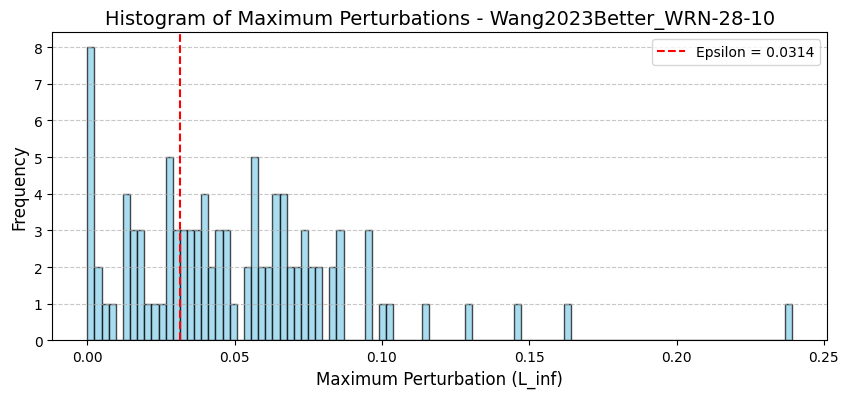

In [18]:
# --- FMN-Linf Histogram of Maximum Perturbations ---
start_fmn = time.time()
_, adv_images_linf, _ = fmn_attacks["Linf"](fmodel, images, labels, epsilons=None)
end_fmn = time.time()

max_perturbations = []
samples_within_epsilon_indices = []  # List to store indices of samples within epsilon
for i in range(len(images)):
    original_image = images[i].cpu().numpy()
    adversarial_image = adv_images_linf[i].cpu().numpy()
    perturbation = np.abs(adversarial_image - original_image)
    max_perturbations.append(np.max(perturbation))

    # Track indices where perturbation is less than or equal to epsilon
    if np.max(perturbation) <= epsilon:
        samples_within_epsilon_indices.append(i)

min_val = min(max_perturbations)
max_val = max(max_perturbations)
num_bins = n_examples
bins = np.linspace(min_val, max_val, num_bins)
if not np.any(np.isclose(bins, epsilon)):
    bins = np.sort(np.append(bins, epsilon))

samples_within_epsilon = len(samples_within_epsilon_indices)
samples_outside_epsilon = len(max_perturbations) - samples_within_epsilon
print(f"\nNumber of samples with max perturbation <= {epsilon:.4f}: {samples_within_epsilon}")
print(f"Number of samples with max perturbation > {epsilon:.4f}: {samples_outside_epsilon}\n")
print(f"Indices of samples with perturbation <= epsilon:\n {samples_within_epsilon_indices}")

plt.figure(figsize=(10, 4))
n, bins_used, patches = plt.hist(max_perturbations, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=epsilon, color='red', linestyle='--', label=f"Epsilon = {epsilon:.4f}")
plt.xlabel("Maximum Perturbation (L_inf)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title(f"Histogram of Maximum Perturbations - {model_name}", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
fmn_linf_histogram_path = os.path.join(output_dir, f"{model_name}_fmn_linf_histogram.png")
plt.savefig(fmn_linf_histogram_path)
print(f"Saved FMN-Linf histogram for {model_name} to: {fmn_linf_histogram_path}")
plt.show()

linf_acc = 100 * torch.sum(labels == model(adv_images_linf).max(1)[1]).item() / len(labels)
fmn_results["Linf"] = {
    "accuracy": linf_acc,
    "execution_time": end_fmn - start_fmn,
    "perturbations": np.array(max_perturbations)
}

model_results[model_name] = {
    "clean_accuracy": clean_accuracy,
    "fmn_results": fmn_results
}
